# Mount Google Drive dan Konfigurasi Direktori

In [2]:
from google.colab import drive
import os
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer # Jika digunakan di preprocessing

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted.")

# Konfigurasi Direktori
BASE_DRIVE_PATH = '/content/drive/My Drive/UAS Penalaran Komputer/'
INPUT_DATA_DIR = os.path.join(BASE_DRIVE_PATH, 'data_processed')
INPUT_FILENAME_CSV = 'cases_representation.csv'
MODEL_OUTPUT_DIR = os.path.join(BASE_DRIVE_PATH, 'models')

print(f"\nDirektori input data: {INPUT_DATA_DIR}")
print(f"Direktori output model: {MODEL_OUTPUT_DIR}")

# Load Data dan Model
input_csv_path = os.path.join(INPUT_DATA_DIR, INPUT_FILENAME_CSV)
try:
    df_cases = pd.read_csv(input_csv_path)
    print(f"Data berhasil dimuat dari: {input_csv_path}")
except FileNotFoundError:
    print(f"ERROR: File '{input_csv_path}' tidak ditemukan. Pastikan path dan nama file benar.")
    exit()
except Exception as e:
    print(f"ERROR saat memuat data: {e}")
    exit()

# Load model pipeline yang sudah dilatih (opsional)
# from joblib import load
# model_path = os.path.join(MODEL_OUTPUT_DIR, 'tfidf_classifier_model.joblib')
# try:
#     pipeline_model = load(model_path)
#     print(f"Model berhasil dimuat dari: {model_path}")
# except FileNotFoundError:
#     print(f"ERROR: Model '{model_path}' tidak ditemukan. Latih ulang model atau pastikan path benar.")
#     exit()
# except Exception as e:
#     print(f"ERROR saat memuat model: {e}")
#     exit()

# Re-define preprocessing components and apply to df_cases
# Download stopwords if not already downloaded
nltk.download('stopwords')


stop_words = set(stopwords.words('indonesian'))
# stemmer = PorterStemmer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # if stemmer: tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df_cases['preprocessed_text_features'] = df_cases['text_full'].apply(preprocess_text)

# Re-define pipeline_model
pipeline_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.8)),
    ('classifier', SVC(kernel='linear', probability=True, random_state=42))
])

# Fit the pipeline model to the preprocessed text features
print("\nFitting the pipeline model...")
pipeline_model.fit(df_cases['preprocessed_text_features'], df_cases['pasal'].fillna('Unknown')) # Using 'pasal' as a dummy target for fitting
print("Pipeline model fitted.")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted.

Direktori input data: /content/drive/My Drive/UAS Penalaran Komputer/data_processed
Direktori output model: /content/drive/My Drive/UAS Penalaran Komputer/models
Data berhasil dimuat dari: /content/drive/My Drive/UAS Penalaran Komputer/data_processed/cases_representation.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Fitting the pipeline model...
Pipeline model fitted.


# Fungsi Solution Reuse

In [3]:
def retrieve_and_reuse_solution(query_text, df_cases, pipeline_model, top_k=3):
    print(f"\n--- Memproses Query untuk Solution Reuse ---")
    print(f"Query Teks: {query_text}")

    # 1. Preprocessing Query
    preprocessed_query = preprocess_text(query_text)
    print(f"Query Teks (Preprocessed): {preprocessed_query}")

    # 2. Case Retrieval (menggunakan Cosine Similarity pada TF-IDF)
    query_vector = pipeline_model.named_steps['tfidf'].transform([preprocessed_query])
    all_case_vectors = pipeline_model.named_steps['tfidf'].transform(df_cases['preprocessed_text_features'])

    similarities = cosine_similarity(query_vector, all_case_vectors).flatten()
    top_k_indices = similarities.argsort()[-top_k:][::-1]

    print(f"\nMenemukan {top_k} kasus paling mirip:")
    retrieved_cases_info = []
    for rank, idx in enumerate(top_k_indices):
        case_info = df_cases.iloc[idx].to_dict()
        case_info['similarity_score'] = similarities[idx]
        retrieved_cases_info.append(case_info)
        print(f"  Rank {rank+1}: Case ID: {case_info['case_id']}, File: {case_info['filename']}, Similarity: {case_info['similarity_score']:.4f}")
        print(f"    No. Perkara: {case_info['no_perkara']}, Tanggal: {case_info['tanggal']}")
        print(f"    Pasal: {case_info['pasal']}")
        # Convert to string and handle potential NaNs before slicing
        amar_putusan_str = str(case_info.get('amar_putusan', '') or '')
        print(f"    Amar Putusan (Singkat): {amar_putusan_str[:150]}...")


    # 3. Solution Reuse: Ekstrak solusi dari kasus yang ditemukan
    recommended_passals = []
    recommended_amar_putusan = []

    for case in retrieved_cases_info:
        if case.get('pasal'):
            recommended_passals.extend([p.strip() for p in str(case['pasal']).split(';') if p.strip()])
        if case.get('amar_putusan'):
            recommended_amar_putusan.append(str(case['amar_putusan']))

    recommended_passals = sorted(list(set(recommended_passals)))

    # 4. Rekomendasi
    recommendations = {
        'query_text': query_text,
        'top_k_retrieved_cases': retrieved_cases_info,
        'recommended_passals': recommended_passals,
        'summary_amar_putusan_from_similar_cases': "\n".join(recommended_amar_putusan[:top_k]) # Ambil amar putusan dari top_k kasus
    }

    return recommendations

# Simulasi Solution Reuse dengan Query Uji

In [4]:
new_queries = [
    {
        'query_text': "Seorang pria ditangkap polisi di Surabaya karena memiliki 5 gram sabu. Ia diduga melanggar undang-undang narkotika tentang kepemilikan.",
        'description': "Kasus baru: kepemilikan sabu 5 gram."
    },
    {
        'query_text': "Ada kasus pengedaran ekstasi besar-besaran di Jakarta. Terdakwa sering menjual barang terlarang ini di diskotik. Pasal yang relevan adalah tentang peredaran narkotika.",
        'description': "Kasus baru: pengedaran ekstasi."
    },
    {
        'query_text': "Seorang wanita tertangkap membawa daun ganja kering untuk konsumsi pribadi. Tidak ada bukti penjualan.",
        'description': "Kasus baru: kepemilikan ganja untuk pribadi."
    },
    {
        'query_text': "Sindikat narkoba internasional tertangkap saat menyelundupkan kokain dalam jumlah besar melalui pelabuhan.",
        'description': "Kasus baru: sindikat internasional, kokain, penyelundupan."
    }
]

print("\n--- Melakukan Solution Reuse untuk Query Baru ---")

for i, query_item in enumerate(new_queries):
    query_text = query_item['query_text']
    description = query_item['description']

    print(f"\n--- Query {i+1}: {description} ---")
    recommendations = retrieve_and_reuse_solution(query_text, df_cases, pipeline_model, top_k=3)

    print("\n--- Rekomendasi Solusi Berdasarkan Kasus Serupa ---")
    print(f"Pasal yang Direkomendasikan: {', '.join(recommendations['recommended_passals']) if recommendations['recommended_passals'] else 'Tidak ditemukan pasal relevan.'}")
    print("\nRingkasan Amar Putusan dari Kasus Paling Mirip:")
    print(recommendations['summary_amar_putusan_from_similar_cases'])
    print("\n" + "="*50) # Pembatas untuk setiap query


--- Melakukan Solution Reuse untuk Query Baru ---

--- Query 1: Kasus baru: kepemilikan sabu 5 gram. ---

--- Memproses Query untuk Solution Reuse ---
Query Teks: Seorang pria ditangkap polisi di Surabaya karena memiliki 5 gram sabu. Ia diduga melanggar undang-undang narkotika tentang kepemilikan.
Query Teks (Preprocessed): pria ditangkap polisi surabaya memiliki 5 gram sabu diduga melanggar undangundang narkotika kepemilikan

Menemukan 3 kasus paling mirip:
  Rank 1: Case ID: 45, File: 855_Pid.Sus_2024_PN Rap.txt, Similarity: 0.0332
    No. Perkara: 855/Pid.Sus/2024/PN Rap, Tanggal: 28 Juli 2024
    Pasal: 1 Angka 1
    Amar Putusan (Singkat): nan...
  Rank 2: Case ID: 26, File: 840_Pid.Sus_2024_PN Rap.txt, Similarity: 0.0311
    No. Perkara: 840/Pid.Sus/2024/PN Rap, Tanggal: 25 Juli 2024
    Pasal: 1 Angka 1
    Amar Putusan (Singkat): 1.Menyatakan Terdakwa Risky Ardiansyah Putra Rambe Alias Kadung tersebut diatas tidak terbukti secara sah dan meyakinkan bersalah melakukan tindak pi

## Visualisasi Distribusi Pasal

Visualisasi berikut menampilkan distribusi frekuensi pasal-pasal yang muncul dalam dataset. Hal ini membantu memahami pasal mana yang paling dominan.

<ipython-input-5-4286224174>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Jumlah Kasus', y='Pasal', data=pasal_counts_top, palette='viridis')


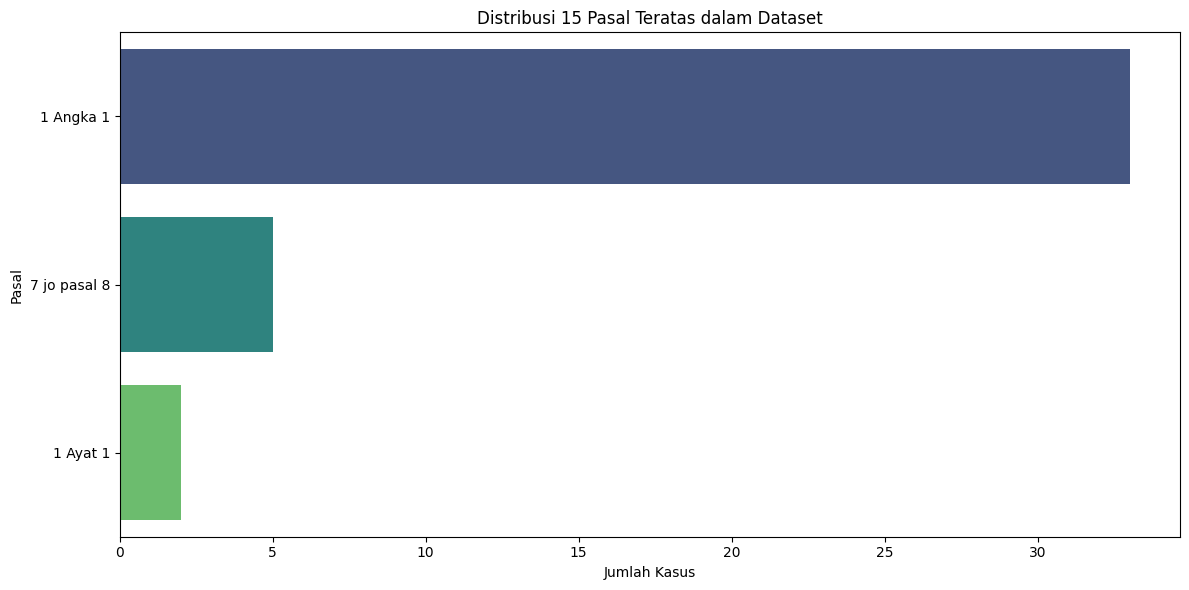

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung frekuensi setiap pasal
pasal_counts = df_cases['pasal'].value_counts().reset_index()
pasal_counts.columns = ['Pasal', 'Jumlah Kasus']

# Ambil 15 pasal teratas untuk visualisasi agar tidak terlalu ramai
top_n = 15
pasal_counts_top = pasal_counts.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x='Jumlah Kasus', y='Pasal', data=pasal_counts_top, palette='viridis')
plt.title(f'Distribusi {top_n} Pasal Teratas dalam Dataset')
plt.xlabel('Jumlah Kasus')
plt.ylabel('Pasal')
plt.tight_layout()
plt.show()